In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import sys
import gc
import pickle


In [2]:
# from xgboost import XGBRegressor
# from xgboost import plot_importance

# def plot_features(booster, figsize):    
#     fig, ax = plt.subplots(1,1,figsize=figsize)
#     return plot_importance(booster=booster, ax=ax)


In [2]:
import os
os.listdir()

['tfvectorizer.ipynb',
 '.ipynb_checkpoints',
 'test.csv',
 'items.csv',
 'data_final.pkl',
 'xgb_submission.csv',
 'future sale prediction.ipynb',
 'all.zip',
 'test.csv.gz',
 'xgb_train.pickle',
 'item shops cats train test.ipynb',
 'sample_submission.csv.gz',
 'sales_train.csv.gz',
 'feature-engineer-and-model-ensemble-top-10.py',
 'future_sale_prediction_final.slides-1.html',
 'future_sale_prediction_final.ipynb',
 'xgb_test.pickle',
 'item_categories.csv',
 'sales_train_v2.csv',
 'future_sale_prediction_final.html',
 'shops.csv']

In [3]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train_v2.csv')
# set index to ID to avoid droping it later
# test  = pd.read_csv('test.csv').set_index('ID')

In [4]:
temp  = pd.read_csv('test.csv')

In [5]:
temp.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [7]:
del temp
gc.collect()

7

In [8]:
test = pd.read_csv('test.csv').set_index('ID')

In [9]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [10]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


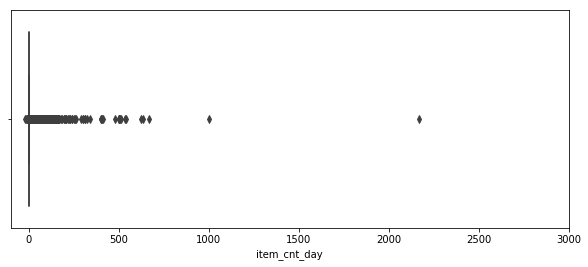

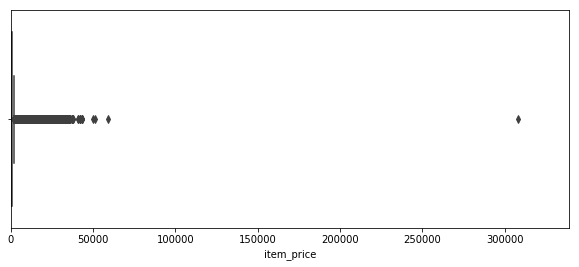

In [14]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)


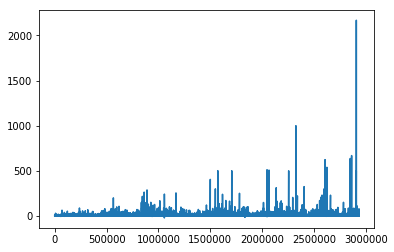

In [15]:
plt.plot(train.item_cnt_day)

/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


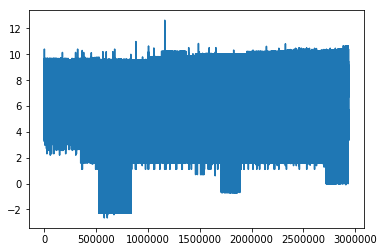

In [16]:
plt.plot(np.log(train.item_price))

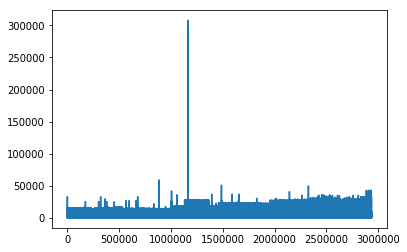

In [17]:
plt.plot(train.item_price)

In [18]:
quar1,quar3 = np.percentile(train.item_cnt_day,[10,90])
iqr = quar3-quar1
low,high = quar1 - (iqr*1.5),quar3+(iqr*1.5)
print('low: %2.3f, high: %2.3f, iqr: %2.3f, min: %3.3f, max: %3.3f'%(low,
                high,iqr,train.item_cnt_day.min(),train.item_cnt_day.max()))

low: -0.500, high: 3.500, iqr: 1.000, min: -22.000, max: 2169.000


In [19]:
print('>100, >500, >1000',
     np.where(train.item_cnt_day>100)[0].shape,
     np.where(train.item_cnt_day>500)[0].shape,
     np.where(train.item_cnt_day>1000)[0].shape)

>100, >500, >1000 (138,) (12,) (1,)


In [20]:
quar1,quar3 = np.percentile(train.item_price,[10,90])
iqr = quar3-quar1
low,high = quar1 - (iqr*1.5),quar3+(iqr*1.5)
print('low: %2.3f, high: %2.3f, iqr: %2.3f, min: %3.3f, max: %3.3f'%(low,
                high,iqr,train.item_price.min(),train.item_price.max()))

low: -2626.000, high: 4774.000, iqr: 1850.000, min: -1.000, max: 307980.000


In [21]:
print('>50000, >75000, >100000',
     np.where(train.item_price>50000)[0].shape,
     np.where(train.item_price>75000)[0].shape,
     np.where(train.item_price>100000)[0].shape)

>50000, >75000, >100000 (3,) (1,) (1,)


In [22]:
np.where(train.item_price<0)

(array([484683]),)

In [23]:
train.iloc[484683]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price                -1
item_cnt_day               1
Name: 484683, dtype: object

In [24]:
train[(train.date_block_num == 4) & (train.shop_id == 32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
479950,25.05.2013,4,32,22155,149.00,1.0
479951,24.05.2013,4,32,22132,149.00,1.0
479952,14.05.2013,4,32,22064,349.00,1.0
479953,31.05.2013,4,32,22042,399.00,1.0
479954,13.05.2013,4,32,21898,499.00,1.0
479955,24.05.2013,4,32,21865,149.00,1.0
479956,02.05.2013,4,32,21841,449.00,1.0
479958,30.05.2013,4,32,21840,149.00,1.0
479959,25.05.2013,4,32,21741,399.00,1.0
479960,29.05.2013,4,32,21730,149.00,1.0


In [25]:
train[(train.date_block_num == 4) & 
      (train.shop_id == 32) & 
      (train.item_id == 2973) &
      (train.item_price > 0)].item_price

484682    1249.0
484684    2499.0
Name: item_price, dtype: float64

In [26]:
print('median calc: ',(2499 + 1249)/2)
median = train[(train.date_block_num == 4) & 
      (train.shop_id == 32) & 
      (train.item_id == 2973) &
      (train.item_price > 0)].item_price
train.loc[train.item_price<0, 'item_price'] = median

median calc:  1874.0


In [27]:
train[train.shop_id == 0].item_id

37589     11059
37590     11059
37591     11059
37592     11347
37593     11347
37594     11061
37595     11064
37596     11065
37597     11065
37598     11065
37599     11065
37600     11077
37601     11080
37602     11081
37603     11083
37604     11093
37605     11094
37606     11095
37607     11095
37608     11095
37609     11095
37610     11359
37611     11131
37612     11131
37613     11134
37614     11059
37615     11135
37616     11045
37617     11041
37618     10928
37619     10933
37620     10939
37621     10945
37622     11334
37623     11336
37624     11336
37625     10974
37626     10980
37627     11005
37628     11005
37629     11009
37630     11012
37631     11027
37632     11030
37633     11031
37634     11032
37635     11032
37636     11041
37637     11041
37638     11041
37639     11041
37640     11041
37641     11041
37642     11041
37643     11041
37644     11136
37645     11136
37646     11151
37647     11388
37648     11388
37649     11389
37650     11389
37651   

In [28]:
shops['shop_name'][[1,57,1,58,10,11]]

1     !Якутск ТЦ "Центральный" фран
57          Якутск Орджоникидзе, 56
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
10       Жуковский ул. Чкалова 39м?
11       Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object

# Fix only the last two match

In [29]:
# # Якутск Орджоникидзе, 56
# train.loc[train.shop_id == 0, 'shop_id'] = 57
# test.loc[test.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [30]:
shops.shop_name.str.split().map(lambda x:x[0])[:5]

0     !Якутск
1     !Якутск
2      Адыгея
3    Балашиха
4    Волжский
Name: shop_name, dtype: object

In [31]:
shops.shop_name.str.split().map(lambda x:x[0:2])[:5]

0    [!Якутск, Орджоникидзе,]
1               [!Якутск, ТЦ]
2                [Адыгея, ТЦ]
3             [Балашиха, ТРК]
4              [Волжский, ТЦ]
Name: shop_name, dtype: object

In [32]:
shops.shop_name.str.split()

0                    [!Якутск, Орджоникидзе,, 56, фран]
1                    [!Якутск, ТЦ, "Центральный", фран]
2                                  [Адыгея, ТЦ, "Мега"]
3                    [Балашиха, ТРК, "Октябрь-Киномир"]
4                         [Волжский, ТЦ, "Волга, Молл"]
5                            [Вологда, ТРЦ, "Мармелад"]
6                        [Воронеж, (Плехановская,, 13)]
7                            [Воронеж, ТРЦ, "Максимир"]
8                     [Воронеж, ТРЦ, Сити-Парк, "Град"]
9                                  [Выездная, Торговля]
10                      [Жуковский, ул., Чкалова, 39м?]
11                      [Жуковский, ул., Чкалова, 39м²]
12                               [Интернет-магазин, ЧС]
13                              [Казань, ТЦ, "Бехетле"]
14                         [Казань, ТЦ, "ПаркХаус", II]
15                            [Калуга, ТРЦ, "XXI, век"]
16                                 [Коломна, ТЦ, "Рио"]
17                   [Красноярск, ТЦ, "Взлетка, 

In [33]:
shops[shops.shop_name == 'Сергиев Посад ТЦ "7Я"']


,shop_name,shop_id
46,"Сергиев Посад ТЦ ""7Я""",46


In [34]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])


In [35]:
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [36]:
shops = shops[['shop_id','city_code']]

In [37]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [38]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# these are russian names(use google translate)

In [39]:
cats.item_category_name[:20]

0        PC - Гарнитуры/Наушники
1               Аксессуары - PS2
2               Аксессуары - PS3
3               Аксессуары - PS4
4               Аксессуары - PSP
5            Аксессуары - PSVita
6          Аксессуары - XBOX 360
7          Аксессуары - XBOX ONE
8                 Билеты (Цифра)
9                Доставка товара
10         Игровые консоли - PS2
11         Игровые консоли - PS3
12         Игровые консоли - PS4
13         Игровые консоли - PSP
14      Игровые консоли - PSVita
15    Игровые консоли - XBOX 360
16    Игровые консоли - XBOX ONE
17      Игровые консоли - Прочие
18                    Игры - PS2
19                    Игры - PS3
Name: item_category_name, dtype: object

In [40]:
cats.item_category_name.str.split('-')[:20]

0        [PC ,  Гарнитуры/Наушники]
1               [Аксессуары ,  PS2]
2               [Аксессуары ,  PS3]
3               [Аксессуары ,  PS4]
4               [Аксессуары ,  PSP]
5            [Аксессуары ,  PSVita]
6          [Аксессуары ,  XBOX 360]
7          [Аксессуары ,  XBOX ONE]
8                  [Билеты (Цифра)]
9                 [Доставка товара]
10         [Игровые консоли ,  PS2]
11         [Игровые консоли ,  PS3]
12         [Игровые консоли ,  PS4]
13         [Игровые консоли ,  PSP]
14      [Игровые консоли ,  PSVita]
15    [Игровые консоли ,  XBOX 360]
16    [Игровые консоли ,  XBOX ONE]
17      [Игровые консоли ,  Прочие]
18                    [Игры ,  PS2]
19                    [Игры ,  PS3]
Name: item_category_name, dtype: object

In [41]:
cats['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())[:20]
# cats['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

0     Гарнитуры/Наушники
1                    PS2
2                    PS3
3                    PS4
4                    PSP
5                 PSVita
6               XBOX 360
7               XBOX ONE
8         Билеты (Цифра)
9        Доставка товара
10                   PS2
11                   PS3
12                   PS4
13                   PSP
14                PSVita
15              XBOX 360
16              XBOX ONE
17                Прочие
18                   PS2
19                   PS3
Name: item_category_name, dtype: object

In [42]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])


In [43]:
cats.head()

,item_category_name,item_category_id,split,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1


In [44]:
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])


In [45]:
cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [46]:
cats = cats[['item_category_id','type_code', 'subtype_code']]


In [47]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [48]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [49]:
items.drop(['item_name'],axis=1, inplace=True)

In [50]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [51]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [52]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [53]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [54]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [55]:
print('shop ids')
train.sort_values(['shop_id'])['shop_id'].unique()

shop ids


array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59])

In [56]:
'total item_ids: ',test.item_id.shape[0],'unique: ',len(list(set(test.item_id)))

('total item_ids: ', 214200, 'unique: ', 5100)

In [57]:
print('train and test items ids intersection: ',len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))))
print('unique in test set: ', len(list(set(test.item_id))))
print('total in test set: ', len(test))


train and test items ids intersection:  363
unique in test set:  5100
total in test set:  214200


In [58]:
train[['date_block_num','shop_id']].count()
# train.groupby(['date_block_num','shop_id']).count()

date_block_num    2935849
shop_id           2935849
dtype: int64

In [59]:
train.groupby(['date_block_num'])['shop_id'].value_counts()[:10]

date_block_num  shop_id
0               31         8439
                54         7526
                25         6971
                28         5720
                0          4793
                27         4696
                42         3474
                6          3254
                46         3008
                50         3006
Name: shop_id, dtype: int64

In [60]:
check = train[train.date_block_num == 0]

In [61]:
check.shape

(115690, 6)

In [62]:
print(check.shop_id.unique().shape[0], check.item_id.unique().shape[0],
     check.shop_id.unique().shape[0]*check.item_id.unique().shape[0])

45 8115 365175


In [63]:
count = 0
for i in product([0], check.shop_id.unique(), check.item_id.unique()):
    count += 1
print(count)

365175


In [64]:
list(product([0], check.shop_id.unique(), check.item_id.unique()))[:6]

[(0, 59, 22154),
 (0, 59, 2552),
 (0, 59, 2554),
 (0, 59, 2555),
 (0, 59, 2564),
 (0, 59, 2565)]

In [65]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), 
                           dtype='int16'))
    
print(time.time() - ts)

5.552679777145386


In [66]:
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

In [67]:
matrix.tail()

,date_block_num,shop_id,item_id
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632
10913849,33,21,7440


In [68]:
ts = time.time()
matrix.sort_values(cols,inplace=True)
print(time.time() - ts)

4.111276865005493


In [69]:
matrix.tail()

,date_block_num,shop_id,item_id
10768834,33,59,22162
10769024,33,59,22163
10769690,33,59,22164
10771216,33,59,22166
10770511,33,59,22167


In [70]:
del check
gc.collect()

21

In [197]:
df = pd.DataFrame({'name':['q','q','a','a'],
                   'address':['a','a','s','s'],
                   'age':[7,8,9,10],
                   'height':[1,3,5,7],
                   'weight':[5,3,6,8]})
df

,name,address,age,height,weight
0,q,a,7,1,5
1,q,a,8,3,3
2,a,s,9,5,6
3,a,s,10,7,8


In [199]:
df.groupby(['name', 'address']).agg({'age':'mean', 'height':sum, 'weight':sum})[['age','height','weight']]


,,age,height,weight
name,address,,,
a,s,9.5,12,14
q,a,7.5,4,8


In [200]:
df.groupby(['name', 'address']).agg({'age':'mean', 'height':sum, 'weight':sum})[['age','height','weight']].reset_index()

,name,address,age,height,weight
0,a,s,9.5,12,14
1,q,a,7.5,4,8


In [71]:
print('total -ve in item_cnt_day: ',np.where(train.item_cnt_day<0)[0].shape[0])
print('total -ve in item_price: ',np.where(train.item_price<0)[0].shape[0])

total -ve in item_cnt_day:  7356
total -ve in item_price:  0


In [72]:
train.item_cnt_day.min(), train.item_cnt_day.max()

(-22.0, 2169.0)

## test here, how to handle item_count negativity (I'm using shifted version)
# Not useful, i checked item_cnt_month become zero for all months except one

In [287]:
# train.item_cnt_day.min(), train.item_cnt_day.max()

(-22.0, 2169.0)

In [286]:
# train.item_cnt_day = train.item_cnt_day-22

In [73]:
train['revenue'] = train['item_price'] * train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


## check first entry of next two block matched

In [74]:
print(train[(train['date_block_num'] == 0) & 
      (train['shop_id'] == 0) & 
      (train['item_id'] == 32)].item_cnt_day.sum())
train[(train['date_block_num'] == 0) & 
      (train['shop_id'] == 0) & 
      (train['item_id'] == 32)].item_cnt_day

6.0


40085    2.0
40086    2.0
40087    1.0
40088    1.0
Name: item_cnt_day, dtype: float64

In [75]:
train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']}).head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [76]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']}).head()

In [77]:
group.columns

MultiIndex(levels=[['item_cnt_day'], ['sum']],
           labels=[[0], [0]])

## here grouping done by month (first column), thus name it as 'item_cnt_month'

In [78]:
group.columns = ['item_cnt_month']
group.head()

item_cnt_month
date_block_num shop_id item_id                
0              0       32                  6.0
                       33                  3.0
                       35                  1.0
                       43                  1.0
                       51                  2.0

In [79]:
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


# Merge

In [80]:
matrix.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [81]:
cols

['date_block_num', 'shop_id', 'item_id']

In [82]:
matrix = pd.merge(matrix,group,on=cols, how='left')

In [83]:
matrix.item_cnt_month.unique(), matrix.item_cnt_month.isnull().sum()

(array([nan,  6.,  3.,  1.,  2.]), 10913845)

In [84]:
group.item_cnt_month.unique()

array([6., 3., 1., 2.])

## didn't do clipping, because all value are outside of range. 
Also it seemed sth wrong, because there are <font color='red'>only four unique</font> value

In [86]:
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).astype(np.float16)

In [87]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [88]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [89]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [90]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month'], dtype='object')

In [91]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.07048964500427246

In [92]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [93]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
time.time() - ts

4.411678314208984

In [94]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,29,40,11,4
1,0,0,27,0.0,29,19,5,10
2,0,0,28,0.0,29,30,8,55
3,0,0,29,0.0,29,23,5,16
4,0,0,32,6.0,29,40,11,4


In [95]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

# Lag features

In [96]:
lag = matrix[['date_block_num','shop_id','item_id','item_cnt_month']][:10000]
shift = lag.copy()
shift.columns = ['date_block_num','shop_id','item_id','lag_item_cnt_month']
shift['date_block_num'] += 1
lag = pd.merge(lag,shift,on=['date_block_num','shop_id','item_id'],how='left')

In [97]:
lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,lag_item_cnt_month
0,0,0,19,0.0,NaN
1,0,0,27,0.0,NaN
2,0,0,28,0.0,NaN
3,0,0,29,0.0,NaN
4,0,0,32,6.0,NaN


In [98]:
del lag,shift
gc.collect()

63

In [99]:
lags = [1,2,3,6,12]

tmp = matrix[['date_block_num','shop_id','item_id','item_cnt_month']]
for i in lags:
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id','item_id', 'item_cnt_month'+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    matrix = pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    del shifted
    gc.collect()

In [100]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN


In [101]:
# del tmp
gc.collect()

0

## Mean encoding feature

In [102]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)


In [103]:
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)


In [104]:
tmp = matrix[['date_block_num','shop_id','item_id','date_avg_item_cnt']]

shifted = tmp.copy()
shifted.columns = ['date_block_num','shop_id','item_id', 'date_avg_item_cnt'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
matrix = pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')


In [105]:
del shifted,tmp
gc.collect()

70

In [106]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,0.000036,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,0.000036,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,0.000036,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,0.000036,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,0.000036,NaN


In [107]:
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [109]:
matrix.date_avg_item_cnt_lag_1.unique()

array([           nan, 3.55839729e-05, 0.00000000e+00])

In [110]:
group.head()

,date_block_num,date_avg_item_cnt
0,0,0.000036
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000


## Seem there is problem, none of item_cnt_month's mean have value except one.

In [111]:
matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['sum']})[:10]

,item_cnt_month
,sum
date_block_num,
0,13.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0


In [112]:
print('matrix size: ',matrix.shape[0])
matrix.isnull().sum()

matrix size:  11128050


date_block_num                   0
shop_id                          0
item_id                          0
item_cnt_month                   0
city_code                        0
item_category_id                 0
type_code                        0
subtype_code                     0
item_cnt_month_lag_1       2505949
item_cnt_month_lag_2       3152271
item_cnt_month_lag_3       3761826
item_cnt_month_lag_6       5397404
item_cnt_month_lag_12      7996293
date_avg_item_cnt_lag_1    2505949
dtype: int64

## Missed many steps of mean encoding lag feature

In [113]:
# group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
# matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)

# tmp = matrix[['date_block_num','shop_id','item_id','date_avg_item_cnt']]

# shifted = tmp.copy()
# shifted.columns = ['date_block_num','shop_id','item_id', 'date_avg_item_cnt'+'_lag_'+str(1)]
# shifted['date_block_num'] += 1
# matrix = pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')

# del shifted,tmp
# gc.collect()

## trending (use average item price and add lagging)

In [114]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

time.time()-ts

2.8777318000793457

In [115]:
ts = time.time()
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)


time.time() - ts

2.689210891723633

In [116]:
ts = time.time()
lags = [1,2]#,3,4,5,6]

tmp = matrix[['date_block_num','shop_id','item_id','date_item_avg_item_price']]
for i in lags:
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id','item_id', 'date_item_avg_item_price'+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    matrix = pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    del shifted
    gc.collect()

time.time()-ts

11.437570571899414

In [118]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [119]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,delta_price_lag_1,delta_price_lag_2
0,0,0,19,0.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,28.000,28.0,NaN,NaN,NaN,NaN
1,0,0,27,0.0,29,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,1461.000,2324.0,NaN,NaN,NaN,NaN
2,0,0,28,0.0,29,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,310.000,549.0,NaN,NaN,NaN,NaN
3,0,0,29,0.0,29,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,1759.000,2398.0,NaN,NaN,NaN,NaN
4,0,0,32,6.0,29,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,249.625,338.0,NaN,NaN,NaN,NaN


In [120]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0


In [121]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)


In [122]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]


In [123]:
print(fetures_to_dropres_to_dropres_to_dropure-engineer-and-model-ensemble-top-10.pyure-engineer-and-model-ensemble-top-10.pyure-engineer-and-model-ensemble-top-10.pyure-engineer-and-model-ensemble-top-10.pyres_to_drop)

['item_avg_item_price', 'date_item_avg_item_price', 'date_item_avg_item_price_lag_1', 'delta_price_lag_1', 'date_item_avg_item_price_lag_2', 'delta_price_lag_2']


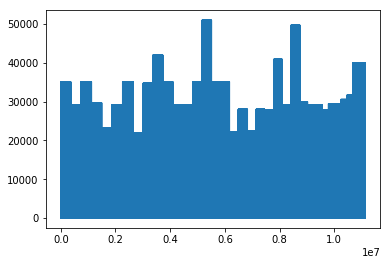

In [124]:
plt.plot(matrix[fetures_to_drop[0]])

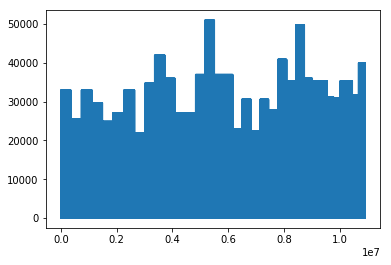

In [125]:
plt.plot(matrix[fetures_to_drop[1]])

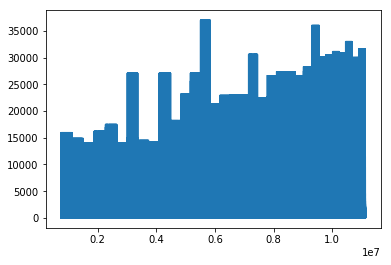

In [127]:
plt.plot(matrix[fetures_to_drop[4]])

In [128]:
matrix.drop(fetures_to_drop, axis=1, inplace=True)


In [129]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)


In [130]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)


In [131]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)


In [136]:
tmp = matrix[['date_block_num','shop_id','item_id','delta_revenue']]
for i in [1]:
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id','item_id', 'delta_revenue'+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    matrix = pd.merge(matrix, shifted, on=['date_block_num','shop_id','item_id'], how='left')



In [137]:
del shifted,tmp
gc.collect()

225

In [138]:
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], 
            axis=1, inplace=True)


In [140]:
matrix['month'] = matrix['date_block_num']%12

In [141]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)


In [143]:
matrix.describe()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
count,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,8.622101e+06,7975779.0,7366224.0,5730646.0,3131757.0,8.622101e+06,1.112805e+07,8.622101e+06,1.112805e+07,1.112805e+07
mean,1.533958e+01,3.130031e+01,1.130368e+04,1.192093e-06,1.530356e+01,4.494411e+01,1.107024e+01,1.810714e+01,1.370907e-06,0.0,0.0,0.0,0.0,1.311302e-06,NaN,NaN,5.268734e+00,3.040316e+01
std,9.760396e+00,1.732035e+01,6.210930e+03,2.141953e-03,8.018806e+00,1.514009e+01,2.854891e+00,2.015450e+01,2.405167e-03,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.418489e+00,8.795090e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,-1.000000e+00,-9.995117e-01,0.000000e+00,2.800000e+01
25%,7.000000e+00,1.600000e+01,5.947000e+03,0.000000e+00,1.000000e+01,3.700000e+01,1.100000e+01,2.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,-2.142334e-02,-2.459717e-01,2.000000e+00,3.000000e+01
50%,1.500000e+01,3.000000e+01,1.138800e+04,0.000000e+00,1.300000e+01,4.000000e+01,1.100000e+01,4.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,-7.025146e-02,5.000000e+00,3.100000e+01
75%,2.300000e+01,4.700000e+01,1.659200e+04,0.000000e+00,2.200000e+01,5.500000e+01,1.300000e+01,3.200000e+01,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,2.937317e-02,1.396484e-01,8.000000e+00,3.100000e+01
max,3.400000e+01,5.900000e+01,2.216900e+04,6.000000e+00,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01,6.000000e+00,0.0,0.0,0.0,0.0,3.558397e-05,1.131250e+01,4.203125e+00,1.100000e+01,3.100000e+01


In [145]:
# cache = {}
# matrix['item_shop_last_sale'] = -1
# matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = str(row.item_id)+' '+str(row.shop_id)
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
#         cache[key] = row.date_block_num         
# time.time() - ts


In [144]:
# cache = {}
# matrix['item_last_sale'] = -1
# matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = row.item_id
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         if row.date_block_num>last_date_block_num:
#             matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
#             cache[key] = row.date_block_num         
